### RNN
RNN is a class of neural network that allows outputs as to used as inputs while having the hidden states.
RNN architectures:

 ![alt txt](Images/rnn_arch.PNG "RNN architecture")



 Work process in each node:
 
 ![alt txt](Images/rnn-process.PNG " work process of rnn")

#### RNN applications

The core reason that RNN are so exciting is that they allow us to operate over sequences of vectors. In traditional NN it has just one to one relationship. For example in image classification the input image and output is of fixed length. RNN allows us to work with sequences. For examples, sequence in our inputs or outputs or both. There are different types of relationships between inputs and outputs. They are-

- one to one : Image classification
- one to many: Image captioning
- many to one: Sentiment classification
- many to many: Machine translation, Video classification

### RNN - PROS & CONS

- Pros:
  - possibility of processing input of any length
  - model size not increasing with size of input
  - computation takes into account historical information : one output acts as input
  - weights are shared accross time

- Cons
  - Computation being slow
  - Difficulty of accessing info from a long time ago
  - cannot consider any future input for the current state
  

Now we will use RNN for name classification

Workflow: We will work with a datasets called names which contains different countries name. We will use a single country name as a sequence then each letter of it as an input of RNN. We will convert our data to ASCII characters.

In [4]:
import io
import os
import unicodedata
import string
import glob

In [2]:
import torch
import random

In [3]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

In [5]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

Load Data

In [6]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories


**Note**:
- To represent a single letter, we use one-hot encoding of size [1 X num_of_letters]
- To represent a single word, we join bunch of those one-hot vectors into a 2D matrix of shape [line_length X 1 X num_of_letters]
  - the extra 1 dimension is because **Pytorch assumes everything** in batches. So, here batch size is 1

In [7]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [8]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [9]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [10]:
def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [12]:
print(ALL_LETTERS)
print(unicode_to_ascii('Ślusàrski'))

category_lines, all_categories = load_data()
print(category_lines['Italian'][:5])

print(letter_to_tensor('J')) # [1, 57]
print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [13]:
import torch.nn as nn
import matplotlib.pyplot as plt


In [17]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [18]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [20]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

In [21]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

In [22]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Portuguese


In [23]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [24]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.5413 Trujillo / Italian WRONG (Spanish)
10000 10.0 1.9983 Robledo / Italian WRONG (Spanish)
15000 15.0 1.3619 Sai / Chinese WRONG (Vietnamese)
20000 20.0 1.2403 Thi / Chinese WRONG (Vietnamese)
25000 25.0 0.6531 Yau / Chinese CORRECT
30000 30.0 2.5167 Bazzi / Italian WRONG (Arabic)
35000 35.0 1.6827 Watoga / Arabic WRONG (Japanese)
40000 40.0 1.3731 Senft / German CORRECT
45000 45.0 0.9426 O'Sullivan / Irish CORRECT
50000 50.0 0.9794 Zhang / Chinese CORRECT
55000 55.00000000000001 1.0882 Faure / French CORRECT
60000 60.0 0.9455 Ha / Korean CORRECT
65000 65.0 2.5763 Samson / Arabic WRONG (French)
70000 70.0 2.2996 Fish / Irish WRONG (English)
75000 75.0 2.0297 Terrazas / Greek WRONG (Spanish)
80000 80.0 2.7115 Adlersflugel / Portuguese WRONG (German)
85000 85.0 1.5847 Mercier / French CORRECT
90000 90.0 0.1911 O'Hare / Irish CORRECT
95000 95.0 0.2987 Conall / Irish CORRECT
100000 100.0 0.2178 O'Hare / Irish CORRECT


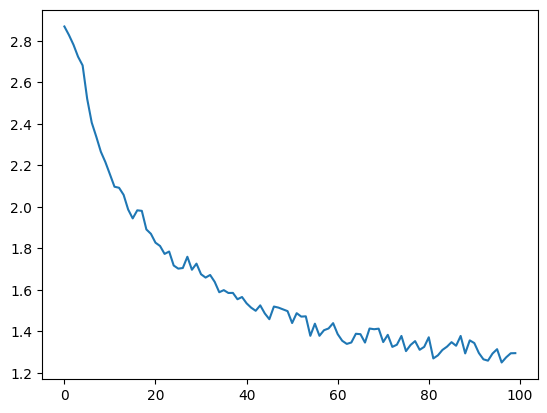

In [25]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [26]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [27]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    predict(sentence)